In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:
df=pd.read_csv('True values/miami_weather_complete.csv')
weather_df=df[['Datetime','actual_max_temp']]
weather_df=pd.DataFrame(weather_df)
weather_df['Datetime']=pd.to_datetime(weather_df['Datetime'])
print(weather_df.head())

    Datetime  actual_max_temp
0 2000-01-01             81.0
1 2000-01-02             79.0
2 2000-01-03             80.0
3 2000-01-04             80.0
4 2000-01-05             80.0


In [48]:
df1 = weather_df.set_index('Datetime')
monthly_maxtemp = df1.resample('M').mean()
monthly_maxtemp.head()

/var/folders/82/lrq6jw85449fhtn35jjj8jf00000gn/T/ipykernel_28696/1641663309.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_maxtemp = df1.resample('M').mean()


,actual_max_temp
Datetime,
2000-01-31,76.258065
2000-02-29,76.931034
2000-03-31,82.451613
2000-04-30,83.033333
2000-05-31,86.870968


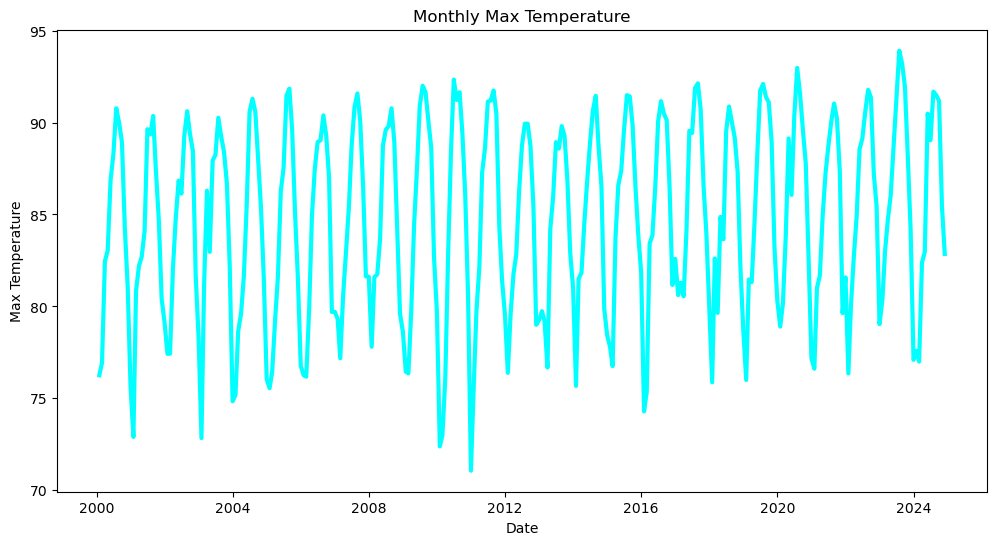

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_maxtemp['actual_max_temp'], linewidth=3,c='cyan')
plt.title("Monthly Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.show()

In [50]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(monthly_maxtemp['actual_max_temp'])

ADF Statistic: -2.782151510395089
p-value: 0.060868874351140426
Non-Stationary


In [51]:
monthly_maxtemp['seasonal_diff'] = monthly_maxtemp['actual_max_temp'].diff(12)  # Assuming monthly data
# Check stationarity again
check_stationarity(monthly_maxtemp['seasonal_diff'].dropna())


ADF Statistic: -5.9576165088634205
p-value: 2.0751904661929583e-07
Stationary


In [52]:
monthly_temp_diff = monthly_maxtemp['seasonal_diff'].dropna()

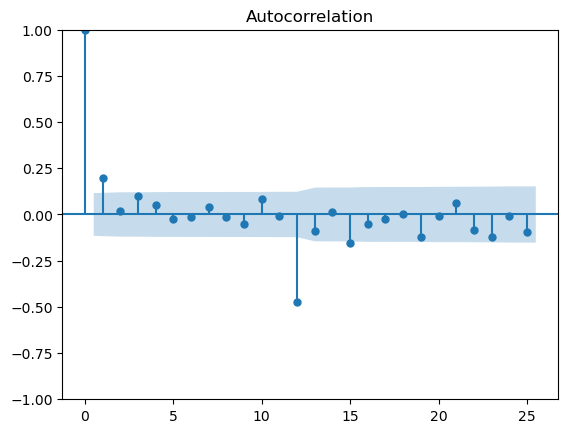

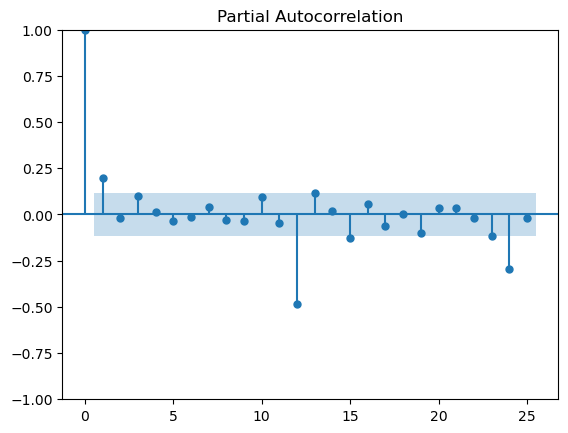

In [53]:
# Plot ACF and PACF
plot_acf(monthly_temp_diff)
plot_pacf(monthly_temp_diff)
plt.show()

In [54]:
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(monthly_temp_diff, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49847D+00    |proj g|=  1.43613D-01


 This problem is unconstrained.



At iterate    5    f=  2.18459D+00    |proj g|=  9.81145D-02

At iterate   10    f=  2.15831D+00    |proj g|=  1.80094D-02

At iterate   15    f=  2.15152D+00    |proj g|=  2.46879D-03

At iterate   20    f=  2.15102D+00    |proj g|=  2.24061D-04

At iterate   25    f=  2.15096D+00    |proj g|=  2.39181D-04

At iterate   30    f=  2.15094D+00    |proj g|=  2.44434D-04

At iterate   35    f=  2.15094D+00    |proj g|=  3.99535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     51      1     0     0   4.829D-06   2.151D+00
  F =   2.1509394899718428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

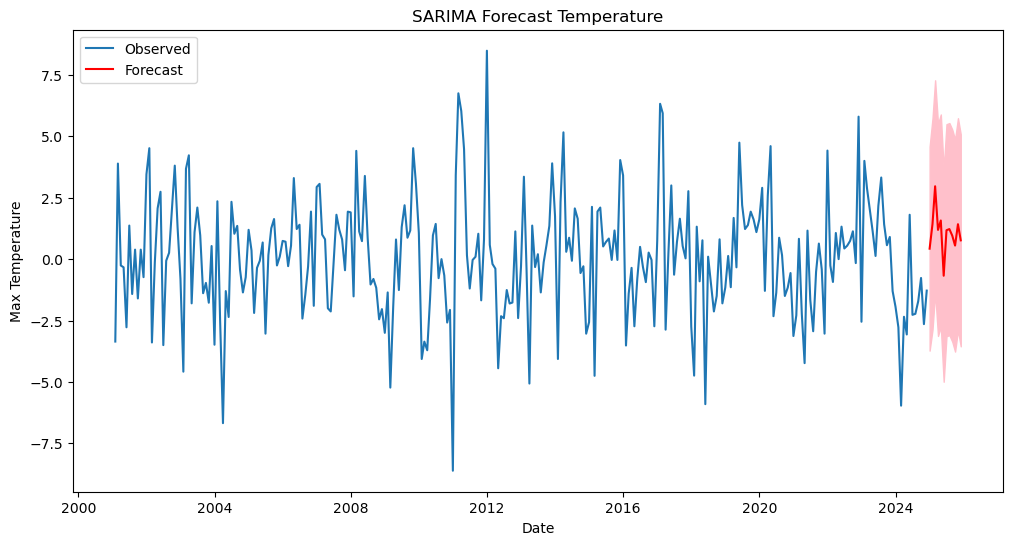

In [57]:
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_temp_diff, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("SARIMA Forecast Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()

In [84]:
observed = monthly_maxtemp[-forecast_periods:]
modified_observed = observed.drop(columns = "actual_max_temp")
mae = mean_absolute_error(modified_observed, forecast_mean)
mse = mean_squared_error(modified_observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 3.595300811505146
MSE: 16.376640250868856
